In [60]:
import wandb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.datasets import fetch_covtype

In [61]:
wandb.login()

True

In [62]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/suyeetan/Downloads/CS5344_Project/work/common/common.py'>

In [63]:
# Function to evaluate and print model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    seconds = time.time()
    # Train the model
    model.fit(X_train, y_train)
    print("Train operation time: = ",time.time()- seconds ,"seconds")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Print model evaluation metrics
    common.evaluate(y_test, y_pred, f"\nModel: {model.__class__.__name__}")

In [64]:
# Dictionary to store models and their names
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine (SVM)": SVC()
}

In [65]:
# project name should correspond to dataset below
# project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
# project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
# project_name = "mba"
# project_name = "tii-ssrc"
# project_name = "cirrhosis"
# project_name = "botnet"
# project_name = "ctu13"
# project_name = "heart"
project_name = "hepatitis"

In [67]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
elif project_name == "mba":
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()
elif project_name == "tii-ssrc":
    %run datasets/tii-ssrc.ipynb
    all_df, main_labels, config = get_processed_tii_ssrc_df()
elif project_name == "cirrhosis":
    %run datasets/cirrhosis.ipynb
    all_df, main_labels, config = get_processed_cirrhosis_df()
elif project_name == "botnet":
    %run datasets/botnet.ipynb
    all_df, main_labels, config = get_processed_botnet_df()
elif project_name == "ctu13":
    %run datasets/ctu13.ipynb
    all_df, main_labels, config = get_processed_ctu13_df()
elif project_name == "heart":
    %run datasets/heart.ipynb
    all_df, main_labels, config = get_processed_heart_df()
else:
    %run datasets/hepatitis.ipynb
    all_df, main_labels, config = get_processed_hepatitis_df()

Normal class:  0    0=Blood Donor
Name: Category, dtype: object
TARGET_DICT {0: '0=Blood Donor', 1: '0s=suspect Blood Donor', 2: '1=Hepatitis', 3: '2=Fibrosis', 4: '3=Cirrhosis'}
NORMAL_TARGET 0
main_labels Index(['Category', 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL',
       'CREA', 'GGT', 'PROT', 'Sex_f', 'Sex_m'],
      dtype='object')


In [68]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,Category,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_f,Sex_m
0,0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0.0,1.0
1,0,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0.0,1.0
2,0,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0.0,1.0
3,0,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0.0,1.0
4,0,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0.0,1.0


In [69]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and testing sets (80% train, 20% test)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(492, 13) (123, 13) (492,) (123,)


In [70]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

Train operation time: =  0.03950977325439453 seconds

Model: LogisticRegression


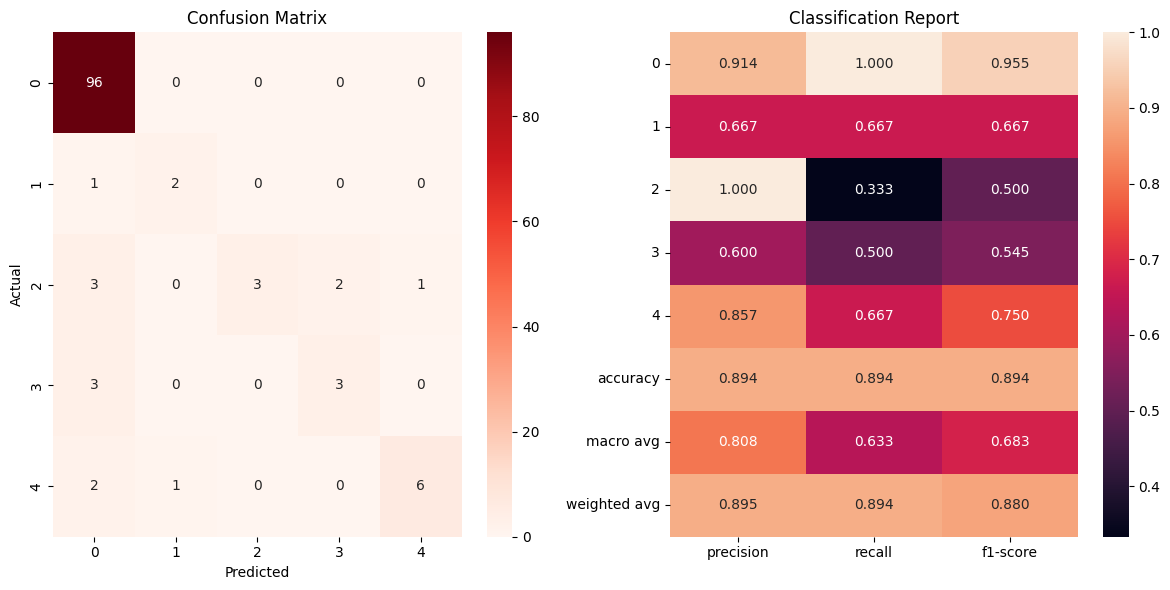

Accuracy: 0.8943089430894309


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.89431
f1-score_avg,0.87987
precision_avg,0.89501
recall_avg,0.89431


Train operation time: =  0.0250089168548584 seconds

Model: DecisionTreeClassifier


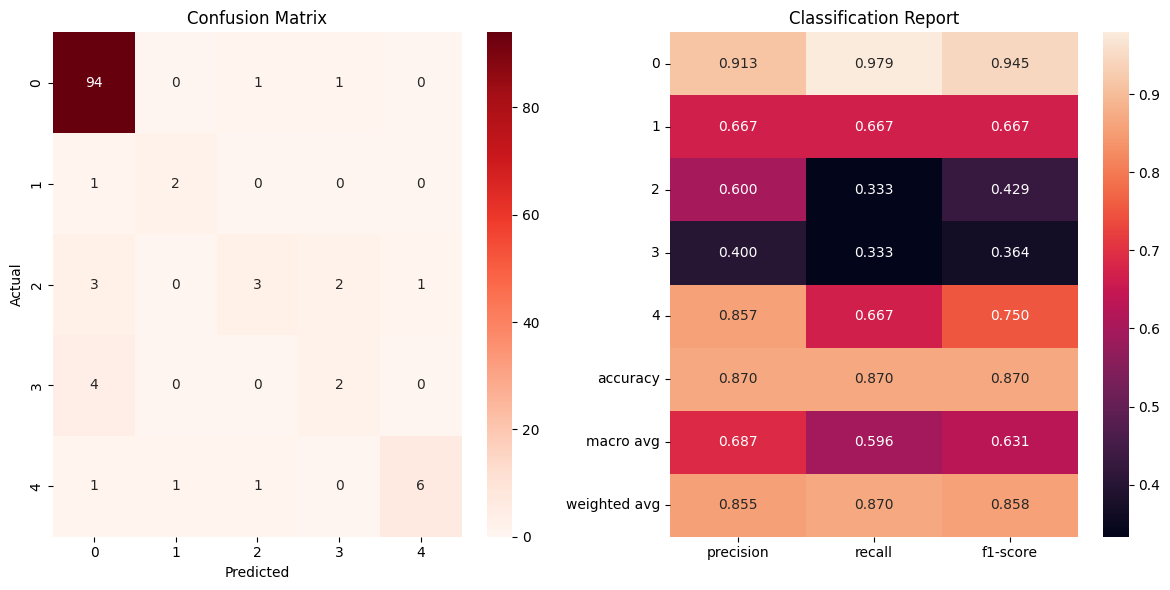

Accuracy: 0.8699186991869918


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.86992
f1-score_avg,0.85758
precision_avg,0.85468
recall_avg,0.86992


Train operation time: =  0.07674980163574219 seconds

Model: RandomForestClassifier


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

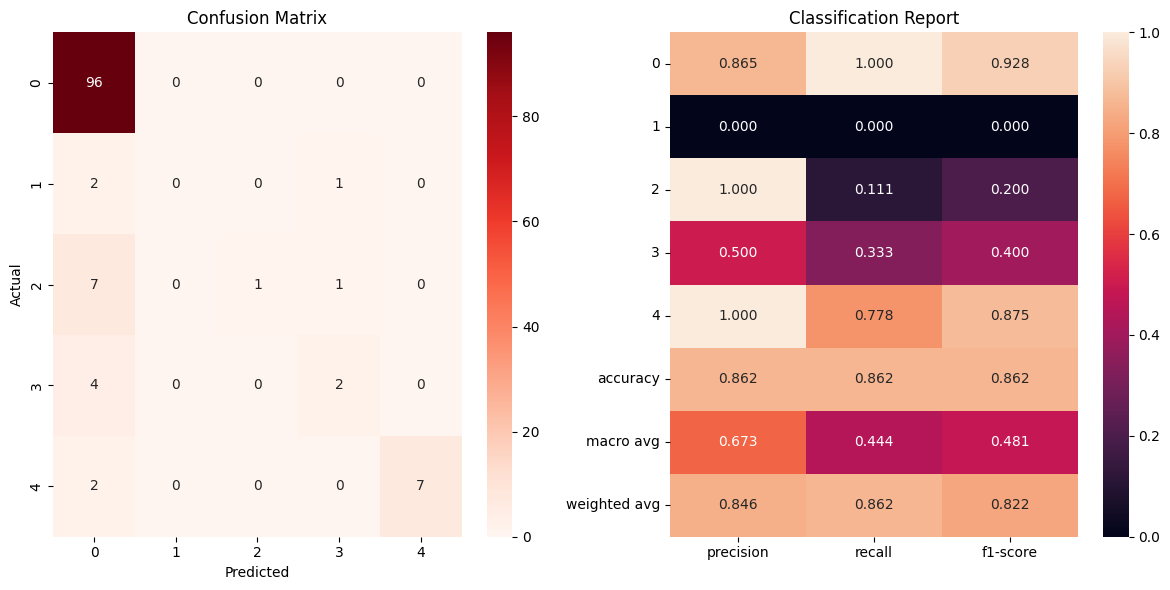

Accuracy: 0.8617886178861789


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.86179
f1-score_avg,0.8221
precision_avg,0.84575
recall_avg,0.86179


Train operation time: =  0.6081180572509766 seconds

Model: GradientBoostingClassifier


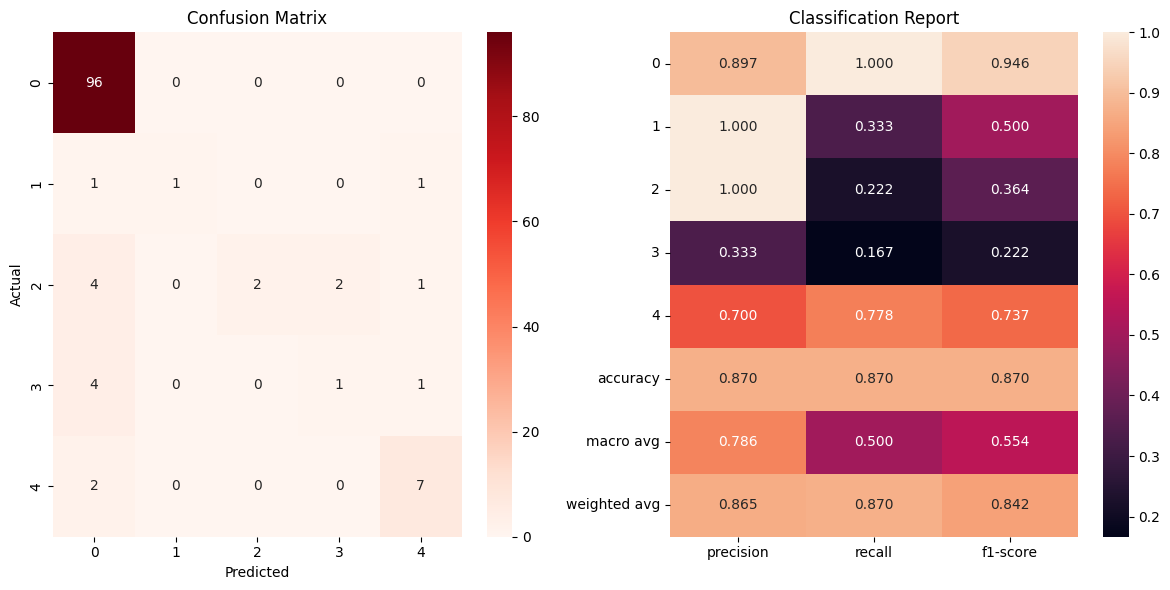

Accuracy: 0.8699186991869918


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.86992
f1-score_avg,0.84175
precision_avg,0.86529
recall_avg,0.86992


Train operation time: =  0.01781487464904785 seconds

Model: KNeighborsClassifier


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

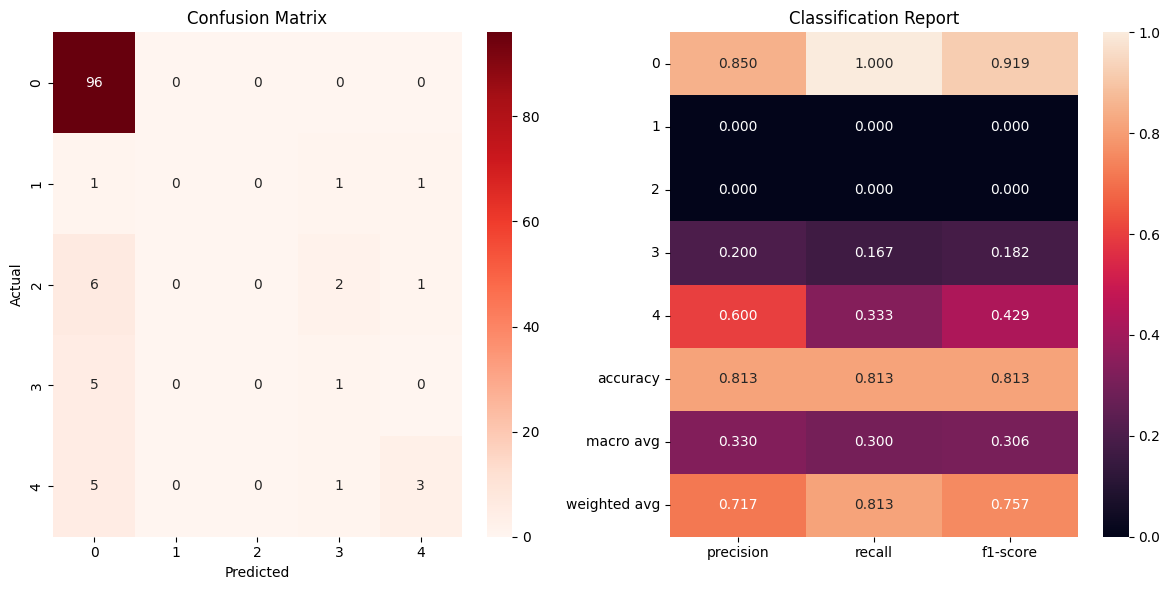

Accuracy: 0.8130081300813008


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.81301
f1-score_avg,0.75723
precision_avg,0.71673
recall_avg,0.81301


Train operation time: =  0.01103520393371582 seconds

Model: SVC


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

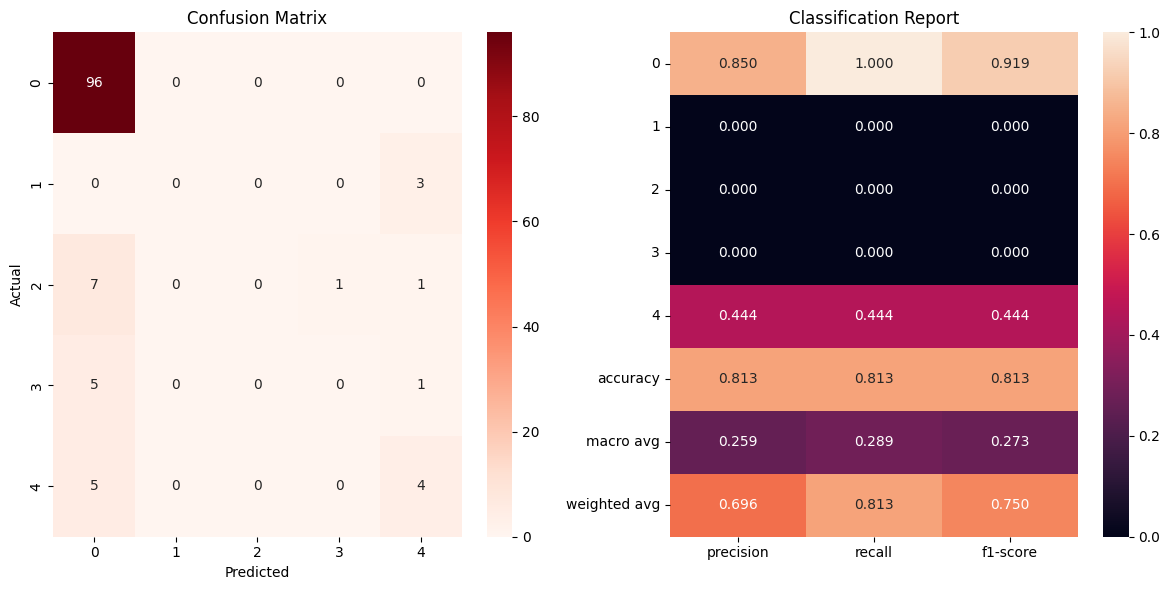

Accuracy: 0.8130081300813008


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.81301
f1-score_avg,0.74952
precision_avg,0.69559
recall_avg,0.81301


Total operation time: =  53.786426067352295 seconds


In [71]:
# Loop through models and evaluate each one
project_name = "baseline-" + project_name
seconds = time.time()
for model_name, model in models.items():
    wandb.init(project=project_name, name=model_name)
    
    # For SVM and Logistic Regression, use scaled data
    if model_name in ["Logistic Regression", "Support Vector Machine (SVM)"]:
        evaluate_model(model, X_train_scaled_df, y_train_df, X_test_scaled_df, y_test_df)
    else:
        evaluate_model(model, X_train_df, y_train_df, X_test_df, y_test_df)
        
    wandb.finish()
print("Total operation time: = ", time.time() - seconds, "seconds")

In [72]:
wandb.finish()